In [ ]:
# this is Saksham's file for ML models
import pandas as pd
import os
from typing import List, Optional, Dict
import gc
import matplotlib.pyplot as plt
import warnings
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

def read_parquet(input_dir: str, years: Optional[List[int]] = None) -> Dict[int, pd.DataFrame]:
    """
    Reads Parquet files for specified years from the input directory.

    Args:
        input_dir (str): The directory where Parquet files are stored.
        years (Optional[List[int]]): A list of years to read. If None, read all available years.

    Returns:
        Dict[int, pd.DataFrame]: A dictionary with years as keys and pandas DataFrames as values.
    """
    data_frames = {}
    available_years = [int(d.split('=')[1]) for d in os.listdir(input_dir) if d.startswith('year=')]
    years_to_read = years if years is not None else available_years

    for year in years_to_read:
        year_path = os.path.join(input_dir, f'year={year}')
        if os.path.exists(year_path):
            df = pd.read_parquet(year_path)
            data_frames[year] = df
        else:
            print(f"Warning: No data found for year {year}")

    return data_frames



if __name__ == "__main__":
    years = [2015, 2016, 2017, 2018, 2019] 
    output_directory = "../data/DS/NSDUH"
    
    # Fetch and save dat
    # Initialize an empty DataFrame to hold all data
    df = pd.DataFrame()

    # Read saved data and concatenate into df
    for year in years:
        df_year = read_parquet(output_directory, [year])
        if year in df_year:
            # Concatenate the current year's DataFrame to df
            df = pd.concat([df, df_year[year]], ignore_index=True)

In [17]:
data_frame = df.copy()

### Hypothesis 2: This hypothesis is to find depression in adult based on his religious belief, smoking/drug activity, ethnicity, age. 

We have combined hypothesis 1, 2, 3 from my phase 1 to comeup with a larger hypthesis for better classification and prediction.

We get the data for our ML ADDPREV is the column that is of importance. Rest all are features

In [18]:
hypothesis_result = data_frame[
    (data_frame['ADDPREV'] >= 1) & (data_frame['ADDPREV'] <= 2) &
    (data_frame['IRINSUR4'] >=1) & (data_frame['IRINSUR4'] <= 2) &
    (data_frame['IRWRKSTAT'] >= 1) & (data_frame['IRWRKSTAT'] <= 4) &
    (data_frame['INCOME'] >= 4) & (data_frame['INCOME'] <= 4) &
    (data_frame['ILLALCFLG'] >= 0) & (data_frame['ILLALCFLG'] <= 1) &
    (data_frame['SNRLGIMP'] >= 1) & (data_frame['SNRLGIMP'] <= 4) &
    (data_frame['SNRLFRND'] >= 1) & (data_frame['SNRLFRND'] <= 4) & #
    (data_frame['SNRLGSVC'] >= 1) & (data_frame['SNRLGSVC'] <= 4) &
    (data_frame['SNRLDCSN'] >= 1) & (data_frame['SNRLDCSN'] <= 4) &
    (data_frame['SEXAGE'] >= 1) & (data_frame['SEXAGE'] <= 5 ) &
    (data_frame['NEWRACE2'] >= 1) & (data_frame['NEWRACE2'] <= 7) 
] 
hypothesis_result['ADDPREV'] = hypothesis_result['ADDPREV'].replace({1: 0, 2: 1})
columns_to_keep = ['ADDPREV', 'IRINSUR4', 'IRWRKSTAT', 'INCOME','ILLALCFLG','SNRLGIMP','SNRLFRND','SNRLGSVC','SNRLDCSN','SEXAGE','NEWRACE2']
hypothesis_result = hypothesis_result[columns_to_keep]

### Feature transformation

We have to find all the combination by performing group by and find the average depression (ADDPREV) per cluster or combination. 
Now when we find the average for per combination and then convert into bins. This bins are new outputs for us as we have to predict the bin. 

We will have only 2 Bins. 

1. 1st bin: Predict the combinations with higher depression probability
2. 2nd bin: predicts the combination of features with lower depression probability

In [19]:
hypothesis_result_avg = hypothesis_result.groupby(['IRINSUR4', 'IRWRKSTAT', 'INCOME', 'ILLALCFLG','SNRLGIMP','SNRLFRND','SNRLGSVC','SNRLDCSN','SEXAGE','NEWRACE2']).agg(
    ADDPREV_avg=('ADDPREV', 'mean'),
    ADDPREV_count=('ADDPREV', 'count')
).reset_index()
hypothesis_result_groupby = hypothesis_result_avg.sort_values(by='ADDPREV_avg', ascending=True)

#### Performing bining

In [20]:
hypothesis_result_avg['ADDPREV_avg_normalized'] = (hypothesis_result_avg['ADDPREV_avg'] - hypothesis_result_avg['ADDPREV_avg'].min()) / (hypothesis_result_avg['ADDPREV_avg'].max() - hypothesis_result_avg['ADDPREV_avg'].min())
bins = [0,0.5,1]
labels = [0,1]
hypothesis_result_avg['ADDPREV_category'] = pd.cut(hypothesis_result_avg['ADDPREV_avg_normalized'], bins=bins, labels=labels, include_lowest=True)
hypothesis_result_transform = hypothesis_result_avg.drop(['ADDPREV_avg', 'ADDPREV_avg_normalized'], axis=1)

The above code performs bining making ADDPREV_category as our new output. We have to assigin any new combination of features to this new output (ADDPREV_category).

1. 1st bin (0): Predict the combinations with higher depression probability
2. 2nd bin (1): predicts the combination of features with lower depression probability

#### Now we need to apply this category to our whole dataset and below code does the same

In [21]:
hypothesis_result_copy = hypothesis_result.copy()
#print(result_data_behavourial_copy)
result_data_behavourial_copy = hypothesis_result_copy.drop(['ADDPREV'], axis=1)

# Perform merge based on the columns of interest
hypothesis_result_copy = hypothesis_result_copy.merge(
    hypothesis_result_transform[['IRINSUR4', 'IRWRKSTAT', 'INCOME', 'ILLALCFLG', 'SNRLGIMP','SNRLFRND','SNRLGSVC','SNRLDCSN','SEXAGE','NEWRACE2','ADDPREV_category']], 
    on=['IRINSUR4', 'IRWRKSTAT', 'INCOME', 'ILLALCFLG', 'SNRLGIMP','SNRLFRND','SNRLGSVC','SNRLDCSN','SEXAGE','NEWRACE2'], 
    how='left'
)

#### Balancing our dataset

As our dataset is Skewed, we need to add synthetic data to balance it. For that we use SMOTE.

It generates synthetic samples for the minority class to address the imbalance, this ensures that we have more balanced dataset for training the model.

SMOTE selects data point from the minority class and finds its nearest neighbors. Then, it creates new synthetic instances by interpolating between the selected data point and the neighbors, this increases minority data points.

In [22]:
import pandas as pd
from imblearn.over_sampling import SMOTE

X = hypothesis_result_copy.drop('ADDPREV_category', axis=1)
y = hypothesis_result_copy['ADDPREV_category']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


### Model 1: Decision Tree

We decided to select Decistion tree because as per phase 1 statistical analysis we figured out that few combinations can be statistically seprated if not all. hence for this purpose we used decision tree.

Accuracy: 97.73093411244301
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     18344
           1       0.98      0.97      0.98     18279

    accuracy                           0.98     36623
   macro avg       0.98      0.98      0.98     36623
weighted avg       0.98      0.98      0.98     36623



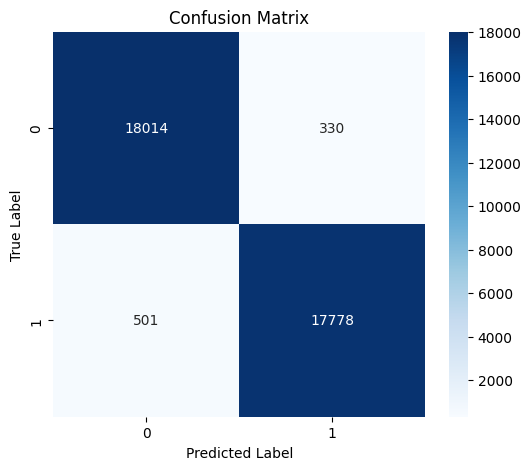

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=42)

tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

y_pred = tree_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy*100)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=tree_model.classes_, yticklabels=tree_model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Decision tree gave 97.7% accuracy which is good

### Model 2: MLPClassifier

MLPClassifier is Multilayer Perceptron Classifier, allows us to learn complex, non-linear relationships in data.

We Choose this Model as we need to fit out data and predict it with bst accuracy and this model (neural net) is best known for function approximation.

Accuracy: 0.9321737705813287
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     18344
           1       0.94      0.92      0.93     18279

    accuracy                           0.93     36623
   macro avg       0.93      0.93      0.93     36623
weighted avg       0.93      0.93      0.93     36623



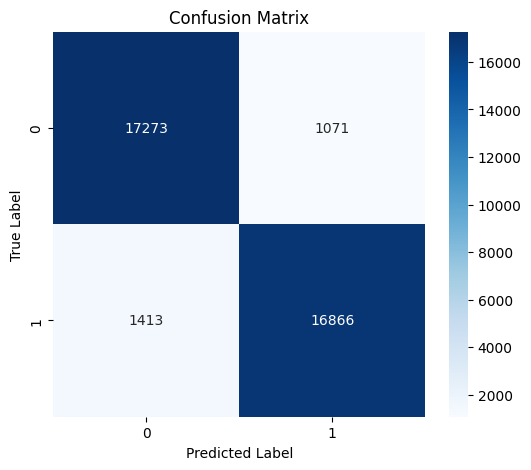

In [26]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=42)

# Train the MLP model with hidden layers
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), random_state=42, max_iter=4000)
mlp_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = mlp_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report for detailed performance
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=mlp_model.classes_, yticklabels=mlp_model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


#### We got an accuracy of 93.21%

This accuracy is not as good as Decision tree. Decision tree is very quick and easy and less complex. Training MLPclassifier takes time and defining it's parameters is also very difficult. 

hence we chose the simplest model with best accuracy which us Decision Tree

#### Observation

| Model            | Accuracy |
|------------------|----------|
| MLPClassifier  | 93.21%      |
| Decision Tree         | 97.7%      |


Decision Tree (97.7% accuracy):
1. It Effectively captures clear patterns in the data.
2. It Well-suited for discrete features with simple splits.
3. It Likely found strong decision boundaries, leading to better performance.
4. It trained faster than MLPClassifier


The Decision Tree achieved 97.7% accuracy because it effectively captures clear patterns in the data with simple splits, making it well-suited for discrete features. It likely found strong decision boundaries, resulting in higher performance.

Reason for not selecting MLPClassifier (93.21% accuracy):

1. it Requires more tuning and sensitive to hyperparameters hence tough to train
2. it many May not have fully leveraged the data’s structure.
3. Slightly lower performance compared to the Decision Tree.
4. Decision tree is a simpler model and much faster than this.

The MLPClassifier, while capable of modeling complex relationships, reached 93.21% accuracy due to the need for more tuning and its sensitivity to hyperparameters. It may not have fully leveraged the data's structure, leading to slightly lower performance compared to the Decision Tree.